In [12]:
import sys
sys.path.append("../Simulations/")

from units import *
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.interpolate import interp1d
from scipy.special import erf, jn, jv, kn
import mpmath as mp
from skmonaco import mcimport, mcquad, mcmiser

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single subhalo

In [2]:
def R0_VL(M0):
    """ Concentration-mass relation for Plummer profile from 1711.03554
    """
    return 1.2*kpc*(M0/(1e8*M_s))**0.5

def c200_SC(M200):
    """ Concentration-mass relation according to Sanchez-Conde&Prada14
    """
    x=np.log(M200*h) # Given in terms of M_s/h in S-C&P paper
    pars=[37.5153, -1.5093, 1.636e-2, 3.66e-4, -2.89237e-5, 5.32e-7][::-1]
    return np.polyval(pars, x)

def get_rs_rhos_NFW(M200):
    """ Get NFW scale radius and density
    """
    c200 = c200_SC(M200/M_s)
    r200 = (M200/(4/3.*np.pi*200*rho_c))**(1/3.)
    rho_s = M200/(4*np.pi*(r200/c200)**3*(np.log(1 + c200) - c200/(1 + c200)))
    r_s = r200/c200
    return r_s, rho_s

def get_rb_rhob_Burk(M200, p):
    """ Get Burkert scale radius and density
    """
    c200n = c200_SC(M200/M_s)
    c200b = c200n/p
    r200 = (M200/(4/3.*mp.pi*200*rho_c))**(1/3.)
    r_b = r200/c200b
    rho_b = M200/(r_b**3*mp.pi*(-2*mp.atan(c200b) + mp.log((1+c200b)**2*(1+c200b**2))))
    return r_b, rho_b

def F(x):
    """ Helper function for NFW deflection, from astro-ph/0102341
    """
    if x > 1:
        return mp.atan(mp.sqrt(x**2-1))/(mp.sqrt(x**2 - 1))
    elif x == 1:
        return 1
    elif x < 1:
        return mp.atanh(mp.sqrt(1-x**2))/(mp.sqrt(1-x**2))
    
def Ft(x, tau):
    """ Helper function for truncated NFW deflection
    """
    return tau**2/(tau**2 + 1)**2*((tau**2 + 1 + 2*(x**2 - 1))*F(x) + tau*mp.pi + (tau**2 - 1)*mp.log(tau) + mp.sqrt(tau**2 + x**2)*(-mp.pi + (tau**2 - 1)/tau*L(x, tau)))

def L(x, tau):
    """ Helper function for truncated NFW deflection
    """
    return mp.log(x/(mp.sqrt(tau**2 + x**2) + tau))

def Fb(x):
    """ Helper function for Burkert deflection
    """
    if x > 1:
        return mp.log(x/2.) + mp.pi/4.*(mp.sqrt(x**2 + 1) - 1) + mp.sqrt(x**2 + 1)/2*mp.acoth(mp.sqrt(x**2 + 1)) - 0.5*mp.sqrt(x**2 - 1)*mp.atan(mp.sqrt(x**2 - 1))
    elif x == 1:
        return -mp.log(2.) - mp.pi/4. + 1/(2*mp.sqrt(2))*(mp.pi + mp.log(3 + 2*mp.sqrt(2)))
    elif x < 1:
        return mp.log(x/2.) + mp.pi/4.*(mp.sqrt(x**2 + 1) - 1) + mp.sqrt(x**2 + 1)/2*mp.acoth(mp.sqrt(x**2 + 1)) + 0.5*mp.sqrt(1 - x**2)*mp.atanh(mp.sqrt(1 - x**2))

In [3]:
def MGauss(theta, M0, beta0):
    """ Enclosed mass in cylinder, Gaussian profile
    """
    return M0*(1-mp.exp(-theta**2/(2*beta0**2)))

def MPlumm(theta, M0, beta0):
    """ Enclosed mass in cylinder, Plummer profile
    """
    return M0*theta**2/(theta**2 + beta0**2)

def MNFW(r, M200):
    """ Enclosed mass in cylinder, NFW profile
    """
    r_s, rho_s = get_rs_rhos_NFW(M200)
    x = r/r_s
    M0 = 4*np.pi*r_s**3*rho_s
    phi_r = M0*(mp.log(x/2) + F(x))
    return phi_r/1e69

def MtNFW(r, M200, tau=15):
    """ Enclosed mass in cylinder, tNFW profile
    """
    r_s, rho_s = get_rs_rhos_NFW(M200)
    x = r/r_s
    M0 = 4*np.pi*r_s**3*rho_s
    phi_r = M0*Ft(x, tau)
    return phi_r/1e69

def MBurk(r, M200, p=0.7):
    """ Enclosed mass in cylinder, Burkert profile
    """
    r_b, rho_b = get_rb_rhob_Burk(M200, p)
    x = r/r_b
    M0 = 4*np.pi*r_b**3*rho_b
    phi_r = M0*Fb(x)
    return phi_r/1e69

In [4]:
def Cl_Gauss(R0, M0, Dl, v, l):
    beta0 = R0/Dl
    return (4*GN*M0*v/Dl**2)**2*np.pi/2.*np.exp(-l**2*beta0**2)

def Cl_Plummer(R0, M0, Dl, v, l):
    beta0 = R0/Dl
    return (4*GN*M0*v/Dl**2)**2*np.pi/2.*l**2*beta0**2*kn(1, l*beta0)**2

def Cl_Point(R0, M0, Dl, v, l):
    beta0 = R0/Dl
    return (4*GN*M0*v/Dl**2)**2*np.pi/2.

def Cl_NFW(M200, Dl, v, l):
    pref = 1e69**2*GN**2*v**2*8*mp.pi*l**2/Dl**4
    Mj = mp.quadosc(lambda theta: MNFW(theta*Dl, M200)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)
    return pref*Mj**2

def Cl_tNFW(M200, Dl, v, l, tau=15):
    pref = 1e69**2*GN**2*v**2*8*mp.pi*l**2/Dl**4
    Mj = mp.quadosc(lambda theta: MtNFW(theta*Dl, M200, tau)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)
    return pref*Mj**2

def Cl_Burk(M200, Dl, v, l, p=0.7):
    pref = 1e69**2*GN**2*v**2*8*mp.pi*l**2/Dl**4
    Mj = mp.quadosc(lambda theta: MBurk(theta*Dl, M200, p)*mp.j1(l*theta), [0, mp.inf], period=2*mp.pi/l)
    return pref*Mj**2

In [5]:
l_min = 1
l_max = 500
n_l = 50
l_ary = np.logspace(np.log10(l_min), np.log10(l_max), n_l)

In [6]:
M0 = 10**8*M_s
R0 = R0_VL(M0)
Dl = 10*kpc
v = 1e-3

In [7]:
Cl_NFW_ary = np.array([Cl_NFW(M0, Dl, v, l) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2
Cl_tNFW_ary = np.array([Cl_tNFW(M0, Dl, v, l, tau=15) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2
Cl_tNFW2_ary = np.array([Cl_tNFW(M0, Dl, v, l, tau=10) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2
Cl_Burk_ary = np.array([Cl_Burk(M0, Dl, v, l) for l in tqdm_notebook(l_ary)])/(1e-6*asctorad/Year)**2

In [8]:
Cl_Plummer_ary = Cl_Plummer(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;
Cl_Gauss_ary = Cl_Gauss(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;
Cl_Point_ary = Cl_Point(R0, M0, Dl, v, l_ary)/(1e-6*asctorad/Year)**2;

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


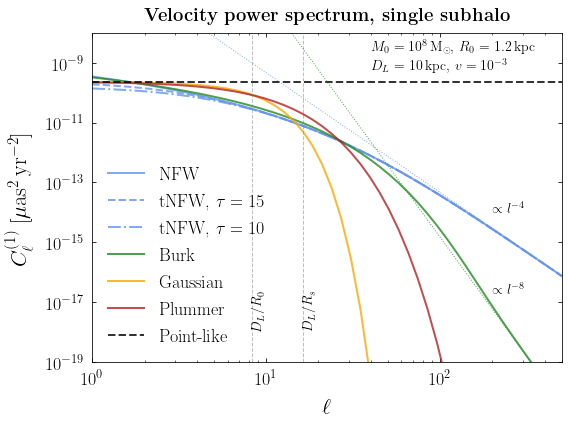

In [9]:
plt.figure(figsize=(8,6))
plt.plot(l_ary, Cl_NFW_ary, label="NFW", alpha=0.8, c='cornflowerblue')
plt.plot(l_ary, Cl_tNFW_ary, label="tNFW, $\\tau = 15$", alpha=0.8, ls='--', c='cornflowerblue')
plt.plot(l_ary, Cl_tNFW2_ary, label="tNFW, $\\tau = 10$", alpha=0.8, ls='-.', c='cornflowerblue')
plt.plot(l_ary, Cl_Burk_ary, label="Burk", alpha=0.8,c='forestgreen')
plt.plot(l_ary, Cl_Gauss_ary, label="Gaussian", alpha=0.8, c='orange')
plt.plot(l_ary, Cl_Plummer_ary, label="Plummer", alpha=0.8, color='firebrick')
plt.plot(l_ary, len(l_ary)*[Cl_Point_ary], label="Point-like", c='k', ls='--', alpha=0.8)

plt.axvline((1/(R0/Dl)), c='grey', lw=1, alpha=0.5, ls='--')
plt.text((1/(R0/Dl)),1e-17,'$D_L/R_0$',rotation=90, fontsize=14)

plt.axvline(1/(get_rs_rhos_NFW(M0)[0]/Dl), c='grey', lw=1, alpha=0.5, ls='--')
plt.text((1/(get_rs_rhos_NFW(M0)[0]/Dl)),1e-17,'$D_L/R_s$',rotation=90, fontsize=14)

n = 4
plt.plot(l_ary, (1/l_ary**n)*Cl_NFW_ary[-1]/(1/(l_ary**n)[-1]), lw=1, alpha=0.8, ls='dotted', c='cornflowerblue')

n = 8
l_base = 2000
fac = Cl_Burk(M0, Dl, v, l_base)/(1e-6*asctorad/Year)**2/(1/(l_base**n))
plt.plot(l_ary, (1/l_ary**n)*fac, lw=1, alpha=0.8, ls='dotted',c='forestgreen')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell^{(1)}$ [$\mu$as$^2$\,yr$^{-2}$]")


plt.xlim(l_min, l_max)
plt.ylim(1e-19,1e-8)

plt.title('\\textbf{Velocity power spectrum, single subhalo}', fontsize=18.5, y=1.02)
plt.text(40, 2.3e-9,'$M_0 = 10^8\,$M$_\odot$, $R_0$ = ' + str(R0/kpc)[:3] + '\,kpc', fontsize=14)
plt.text(40, 5e-10,'$D_L$ = 10\,kpc, $v=10^{-3}$', fontsize=14)

plt.text(200, 1e-14,'$\propto l^{-4}$', fontsize=14)
plt.text(200, 2e-17,'$\propto l^{-8}$', fontsize=14)

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig("single_sub.pdf")

# Populations

### Set some parameters

In [13]:
Rsun = 8*kpc
Rmin = 1*kpc
Rmax = 200*kpc
M_min = 1e7*M_s
M_max = 1e12*M_s

In [14]:
v0 = 220.*Kmps
vesc = 544.*Kmps
vsun = (11.*Kmps, 12.*Kmps + v0, 7.*Kmps)

Nesc = erf(vesc/v0) - 2/np.sqrt(np.pi)*vesc/v0*np.exp(-vesc**2/v0**2)

In [15]:
DM_frac = 0.2

### Define some distributions

In [16]:
def rho_nfw(r):
    """Unnormalized NFW profile density"""
    r_s = 18*kpc
    return r**2*1/((r/r_s)*(1+r/r_s)**2)

def rho_v(v):
    """Unnormalized SHM Maxwellian"""
    v0 = 220*Kmps
    if v > 550*Kmps: return 0
    return np.exp(-v**2/v0**2)

def rho_m(ms):
    """ Mass function
    """
    A0 = 2e8/M_s
    dNcdmdm = A0*(ms/M_s)**-1.9
    return dNcdmdm

def rho_v(vvec):
    """ Truncated Maxwellian velocity distribution
    """
    v = np.linalg.norm(vvec)
    return 1/(Nesc*np.pi**1.5*v0**3)*np.exp(-v**2/v0**2)*(v < vesc)

def vproj(v, theta, phi, thetap, phip):
    """ Projected velocity in a given direction
    """
    v_vec = v*np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    theta_hat = np.array([np.cos(thetap)*np.cos(phip), np.cos(thetap)*np.sin(phip), -np.sin(thetap)])
    phi_hat = [-np.sin(phip), np.cos(phip), 0]
    return np.sqrt(np.dot(v_vec,theta_hat)**2 + np.dot(v_vec,phi_hat)**2)

def R0_VL(M0):
    """ "Concentration-mass" relation for Plummer profile from 1711.03554
    """
    return 1.2*kpc*(M0/(1e8*M_s))**0.5

### Some normalization factors

In [17]:
norm_rho_nfw = nquad(lambda l, theta: rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta))), [[Rmin,Rmax],[0,2*np.pi]])[0]

In [18]:
norm_rho_m = quad(lambda m: rho_m(m), M_min, M_max)[0]
m_avg = quad(lambda m: m*rho_m(m), M_min, M_max)[0]/norm_rho_m
N_halos = DM_frac*1/(m_avg/(1e12*M_s))

In [20]:
thetap, phip = np.pi/2., np.pi/2.
v_term, _ = nquad(lambda v, theta, phi: v**2*(vproj(v, theta, phi, thetap, phip))**2*np.sin(theta)*rho_v(v),
      [[0,950.*Kmps],[0,np.pi],[0,2*np.pi]])

### Calculate population integral

In [28]:
l_min = 10
l_max = 2000
n_l = 50

l_ary = np.arange(l_min,l_max)
l_ary_calc = np.logspace(np.log10(l_min), np.log10(l_max), n_l)

In [29]:
def f(x, ell):
    l, theta, logm = x[0], x[1], x[2]
    m = 10**logm*M_s
    return m*Cl_Plummer(R0_VL(m), m, l, 1, ell) / (1e-6*asctorad/Year)**2  * rho_m(m) * rho_nfw(np.sqrt(l**2 + Rsun**2 - 2*l*Rsun*np.cos(theta)))

conv_fid = [mcquad(lambda x: f(x, ell), npoints=1e5, xl=[Rmin,0,np.log10(M_min/M_s)], xu=[Rmax,2*np.pi,np.log10(M_max/M_s)], nprocs=5)[0] for ell in tqdm_notebook(l_ary_calc)]


In [30]:
C_l_fid = N_halos*np.array(conv_fid) * v_term / norm_rho_m / norm_rho_nfw

In [31]:
C_l_fid_interp = np.interp(l_ary, l_ary_calc, C_l_fid)

(1e-19, 1e-05)

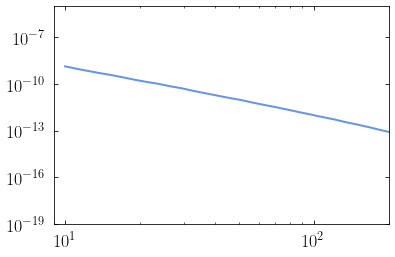

In [33]:
plt.plot(l_ary_calc, C_l_fid)
plt.yscale("log")
plt.xscale("log")
plt.xlim(9, 200)
plt.ylim(1e-19,1e-5)